# Import

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import math
import glob
import json
import seaborn as sns
from scipy.ndimage import gaussian_filter
from torchviz import make_dot, make_dot_from_trace
from skimage import io, transform
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility
from torch._six import container_abcs, string_classes, int_classes
import re
np_str_obj_array_pattern = re.compile(r'[SaUO]')
default_collate_err_msg_format = (
    "default_collate: batch must contain tensors, numpy arrays, numbers, "
    "dicts or lists; found {}")

# plt.rcParams['font.size'] = 60
# # plt.rcParams['font.weight'] = 'bold'
# # plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['lines.linewidth'] = 10
# plt.rcParams['lines.markersize'] = 15


# 1 Common modules

In [2]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)
        return matrix.astype(np.float32)


class UniformNormalize:
    '''Set a uniform threshold accross all samples
    '''
    
    def __init__(self, noise_floor):
        self.noise_floor = noise_floor

    def __call__(self, matrix):
        matrix -= self.noise_floor
        matrix /= (-self.noise_floor/2)
        return matrix.astype(np.float32)

    
class PuNormalize:
    '''only subtract the floor value
    '''
    
    def __init__(self, floor):
        self.floor = floor
    
    def __call__(self, matrix):
        matrix -= self.floor
        return matrix.astype(np.float32)

class Metrics:
    '''Evaluation metrics
    '''
    @staticmethod
    def localization_error_image_continuous(pred_batch, pred_ntx, truth_batch, index, grid_len, peak_threshold, debug=False):
        '''Continuous -- for single TX
           euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
           now both prediction and truth are continuous numbers
        Args:
            pred_batch:  numpy.ndarray -- size=(N, 1, 100, 100)
            truth_batch: numpy.ndarray -- size=(N, num_tx, 2)
        Return:
            pred_locs -- list<np.ndarray>
            errors    -- list<list>
            misses    -- list
            false     -- list
        '''
        def float_target(pred_matrix, pred_peaks):
            new_pred_peaks = []
            for pred_x, pred_y in pred_peaks:
                sum_weight = 0
                neighbor = []
                for d in [(0, 0), (-1, 0), (0, 1), (1, 0), (0, -1)]:
                    nxt = (pred_x + d[0], pred_y + d[1])
                    if 0 <= nxt[0] < grid_len and 0 <= nxt[1] < grid_len:
                        neighbor.append(((nxt[0] + 0.5, nxt[1] + 0.5), pred[nxt[0]][nxt[1]]))
                        sum_weight += pred_matrix[nxt[0]][nxt[1]]
                pred_x, pred_y = 0, 0
                for n in neighbor:
                    loc = n[0]
                    w   = n[1]
                    pred_x += loc[0] / sum_weight * w
                    pred_y += loc[1] / sum_weight * w
                new_pred_peaks.append((pred_x, pred_y))
            return new_pred_peaks

        pred_locs = []
        errors = []
        misses = []
        falses = []
        for i, pred, pred_n, truth, indx in zip(range(len(pred_batch)), pred_batch, pred_ntx, truth_batch, index):
            # 1: get the multiple predicted locations
            pred = pred[0]           # there is only one channel
            pred_peaks, _ = Utility.detect_peak(pred, np.round(pred_n, 0), peak_threshold)         # get the predictions  TIME: 23 milliseconds
            pred_peaks = float_target(pred, pred_peaks)
            # 2: do a matching and get the error
            radius_threshold = Default.grid_length * Default.error_threshold
            error, miss, false = Utility.compute_error(pred_peaks, truth, radius_threshold, False)
            errors.append(error)
            misses.append(miss)
            falses.append(false)
            if debug:
                print(i, indx, 'pred', [(round(loc[0], 2), round(loc[1], 2)) for loc in pred_peaks], '; truth', \
                      [(round(loc[0], 2), round(loc[1], 2)) for loc in truth], ' ; error', error, ' ; miss', miss, ' ; false', false)
        return errors, misses, falses

    @staticmethod
    def mseloss(pred, y):
        '''
        Args:
            pred -- np.ndarray, n=2
            y    -- np.ndarray, n=2
        Return:
            float
        '''
        n = len(pred) * len(pred[0])
        summ = np.sum((pred - y)**2)
        return summ / n

In [3]:
def my_padding(batch, max_len):
    """add zeros to elements that are not maximum length"""
    for i in range(len(batch)):
        diff = max_len - len(batch[i])
        if diff > 0:                      # padding
            if len(batch[i].shape) == 1:
                zeros = torch.zeros(diff)
            elif len(batch[i].shape) == 2:
                zeros = torch.zeros(diff, 2)
            else:
                raise('unsupported dimension in my_padding')
            padded = torch.cat((batch[i], zeros), 0)
            batch[i] = padded


def my_collate(batch):
    """Puts each data field into a tensor with outer dimension batch size"""
    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, torch.Tensor):
        max_len = len(max(batch, key=len))
        min_len = len(min(batch, key=len))
        if max_len != min_len:
            my_padding(batch, max_len)
        out = None
        if torch.utils.data.get_worker_info() is not None:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = elem.storage()._new_shared(numel)
            out = elem.new(storage)
        return torch.stack(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        if elem_type.__name__ == 'ndarray' or elem_type.__name__ == 'memmap':
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError(default_collate_err_msg_format.format(elem.dtype))

            return my_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)
    elif isinstance(elem, float):
        return torch.tensor(batch, dtype=torch.float64)
    elif isinstance(elem, int_classes):
        return torch.tensor(batch)
    elif isinstance(elem, string_classes):
        return batch
    elif isinstance(elem, container_abcs.Mapping):
        return {key: my_collate([d[key] for d in batch]) for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, '_fields'):  # namedtuple
        return elem_type(*(my_collate(samples) for samples in zip(*batch)))
    elif isinstance(elem, container_abcs.Sequence):
        # check to make sure that the elements in batch have consistent size
        it = iter(batch)
        elem_size = len(next(it))
        if not all(len(elem) == elem_size for elem in it):
            raise RuntimeError('each element in list of batch should be of equal size')
        transposed = zip(*batch)
        return [my_collate(samples) for samples in transposed]

    raise TypeError(default_collate_err_msg_format.format(elem_type))


def my_uncollate(y_num, y_float):
    """this is for uncollating the target_float"""
    y_float_tmp = []
    for ntx, y_f in zip(y_num, y_float):
        y_float_tmp.append(y_f[:ntx])
    return np.array(y_float_tmp, dtype=object)


def get_sen_num(idx, root_dir='data/205test', sample_per_label=5):
    folder = int(idx / sample_per_label)
    folder = format(folder, '06d')
    json_name = str(idx % sample_per_label) + '.json'
    json_path = os.path.join(root_dir, folder, json_name)
    with open(json_path, 'r') as f:
        json_dict = json.loads(f.read())
    return len(json_dict['sensor_data'])

# 2 Dataset

## Dataset & Dataloader

In [4]:
class SensorInputDatasetTranslation(Dataset):
    '''Sensor reading input dataset -- for multi TX
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, transform=None, transform_pu=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.transform_pu = transform_pu
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label()

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder = int(idx / self.sample_per_label)
        folder = format(folder, '06d')
        matrix_name = str(idx % self.sample_per_label) + '.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        target_name = str(idx % self.sample_per_label) + '.target.npy'
        target_img, target_float = self.get_translation_target(folder, target_name)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        target_num = len(target_float)
        power_name = str(idx % self.sample_per_label) + '.power.npy'
        power_path = os.path.join(self.root_dir, folder, power_name)
        power = np.load(power_path)
        matrix_auth_name = str(idx % self.sample_per_label) + '.auth.npy'
        matrix_auth_path = os.path.join(self.root_dir, folder, matrix_auth_name)
        matrix_auth = np.load(matrix_auth_path)
        if self.transform:
            matrix_auth = self.transform(matrix_auth)
        target_auth_float_name = str(idx % self.sample_per_label) + '.auth.target.npy'
        target_auth_float_path = os.path.join(self.root_dir, folder, target_auth_float_name)
        target_auth_float = np.load(target_auth_float_path)
        power_auth_name = str(idx % self.sample_per_label) + '.auth.power.npy'
        power_auth_path = os.path.join(self.root_dir, folder, power_auth_name)
        power_auth = np.load(power_auth_path)
        pu_matrix = self.get_pu_matrix(target_auth_float, power_auth)
        if self.transform_pu:
            pu_matrix = self.transform_pu(pu_matrix)
        two_sheet = np.stack((matrix_auth[0], pu_matrix[0]), axis=0)
        sample = {'matrix': matrix, 'target': target_img, 'target_float': target_float, 'target_num': target_num, 'power': power, 'index': idx, \
                 'matrix_auth': matrix_auth, 'target_auth_float': target_auth_float, 'power_auth': power_auth, 'pu_matrix': pu_matrix, 'two_sheet': two_sheet}
        return sample

    def get_pu_matrix(self, target_auth_float, power_auth):
        '''The sheet for PU, each PU is a circle
        Args:
            target_auth_float -- np.ndarray, n=3 -- a list of 2D locations
            power_auth        -- np.ndarray, n=2 -- a list of power values
        Return:
            np.ndarray, n = 2
        '''
        grid = np.zeros((Default.grid_length, Default.grid_length))
        for (x, y), power in zip(target_auth_float, power_auth):
            x, y = int(x), int(y)
            for i in [-3, -2, -1, 0, 1, 2, 3]:
                for j in [-3, -2, -1, 0, 1, 2, 3]:
                    nxt = (x + i, y + j)
                    if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                        val = self.gaussian_cust(power + 10, x + 0.5, y + 0.5, nxt[0] + 0.5, nxt[1] + 0.5)
                        grid[nxt[0]][nxt[1]] = max(val, grid[nxt[0]][nxt[1]])
        return grid.astype(np.float32)
    
    def get_sample_per_label(self):
        folder = glob.glob(os.path.join(self.root_dir, '*'))[0]
        samples = glob.glob(os.path.join(folder, '*.json'))
        return len(samples)

    def gaussian(self, b_x, b_y, x, y):
        '''2D gaussian
        '''
        a, c = 10, 0.9
        dist = math.sqrt((x - b_x) ** 2 + (y - b_y) ** 2)
        return a * np.exp(- dist ** 2 / (2 * c ** 2))
    
    def gaussian_cust(self, a, b_x, b_y, x, y):
        '''2D gaussian
        '''
        c = 0.9
        dist = math.sqrt((x - b_x) ** 2 + (y - b_y) ** 2)
        return a * np.exp(- dist ** 2 / (2 * c ** 2))

    def get_translation_target(self, folder: str, target_name: str):
        '''try guassian peak
        Args:
            folder      -- eg. 000001
            target_name -- eg. 0.target.npy
        Return:
            np.ndarray, n = 2, the pixels surrounding TX will be assigned some values
        '''
        location = np.load(os.path.join(self.root_dir, folder, target_name))
        num_tx = len(location)
        grid = np.zeros((Default.grid_length, Default.grid_length))
        for i in range(num_tx):
            x, y = location[i][0], location[i][1]
            target_float = (x, y)
            x, y = int(x), int(y)
            for i in [-2, -1, 0, 1, 2]:
                for j in [-2, -1, 0, 1, 2]:
                    nxt = (x + i, y + j)
                    if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                        val = self.gaussian(target_float[0], target_float[1], nxt[0]+0.5, nxt[1]+0.5)
                        grid[nxt[0]][nxt[1]] = max(val, grid[nxt[0]][nxt[1]])
        grid = np.expand_dims(grid, 0)
        return grid.astype(np.float32), location.astype(np.float32)


    def save_object_detection_image(self, output_dir, pred_matrix, idx):
        '''Take a 2D matrix (one channel image) as input, output as an image with three channels (by duplication)
        Args:
            pred_matrix -- np.ndarray, n=2
        '''
        img = np.stack((pred_matrix, pred_matrix, pred_matrix), axis=2)
        filename = format(idx, '06d')
        path = os.path.join(output_dir, filename)
        np.save(path, img.astype(np.float32))
        return filename

    def save_object_detection_label(self, output_dir, idx, grid_len, pred_matrix, peak_threashold=0.3, debug=False):
        filename = format(idx, '06d') + '.txt'
        path = os.path.join(output_dir, filename)
        with open(path, 'w') as f:
            sample = self.__getitem__(idx)
            ground_truth = sample['target_float']
            for x, y in ground_truth:
                if debug:
                    print(x, y)
                if pred_matrix[int(x)][int(y)] > peak_threashold:
                    f.write('0 {} {} {} {}\n'.format(y / grid_len, x / grid_len, 5 / grid_len, 5 / grid_len))
                else:
                    print(f'index = {idx} no peak at ({x}, {y}), value is {pred_matrix[int(x)][int(y)]}')


tf = T.Compose([
     UniformNormalize(Default.noise_floor),                 # TUNE: Uniform normalization is better than the above minmax normalization
     T.ToTensor()])

tf_pu = T.Compose([
#      PuNormalize(-2.5),
     T.ToTensor()])

# training
i = 2029
root_dir = './data/1005train'
sensor_input_dataset = SensorInputDatasetTranslation(root_dir=root_dir, transform=tf, transform_pu=tf_pu)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3, collate_fn=my_collate)
print('matrix shape:', sensor_input_dataset[i]['matrix'].shape)
print('matrix shape:', sensor_input_dataset[i]['matrix'])
print('target:', sensor_input_dataset[i]['target'])
print('target float:', sensor_input_dataset[i]['target_float'])
print('two sheet shape:', sensor_input_dataset[i]['two_sheet'].shape)
print('length:', sensor_input_dataset.__len__())

# fig, ax = plt.subplots(1, figsize=(5, 4))
# sns.heatmap(sensor_input_dataset[i]['target'][0][0:5, 0:5], annot=True)


print('---\n')
# testing
root_dir = './data/1005test'
sensor_input_test_dataset = SensorInputDatasetTranslation(root_dir=root_dir, transform=tf, transform_pu=tf_pu)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3, collate_fn=my_collate)
print('matrix type:', sensor_input_test_dataset[i]['matrix'].dtype)
print('target type:', sensor_input_test_dataset[i]['target'].dtype)
print('target float:', sensor_input_test_dataset[i]['target_float'])
print('target num:', sensor_input_test_dataset[i]['target_num'])
print(sensor_input_test_dataset.__len__())

matrix shape: torch.Size([1, 100, 100])
matrix shape: tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.3034, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
target: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
target float: [[ 4.610243 12.80315 ]
 [63.870007 27.914194]
 [52.810364 30.825188]
 [11.99795  50.037514]
 [33.918854 31.87196 ]
 [71.62899  22.355272]
 [49.555435 20.27544 ]
 [29.35469  64.49344 ]
 [ 2.572477 59.473373]]
two sheet shape: (2, 100, 100)
length: 92160
---

matrix type: torch.float32
target type: float32
target float: [[ 6.7716155 23.704325 ]
 [19.6236

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


intruder
 [[23.546244 57.36921 ]
 [65.5775   61.252663]
 [19.59528  44.9594  ]
 [ 4.998027 62.476334]]
authorized
 [[10.661987 18.028614]
 [20.40537  85.636055]
 [48.25586  47.068275]
 [90.055    10.551345]
 [89.67088  80.83941 ]]


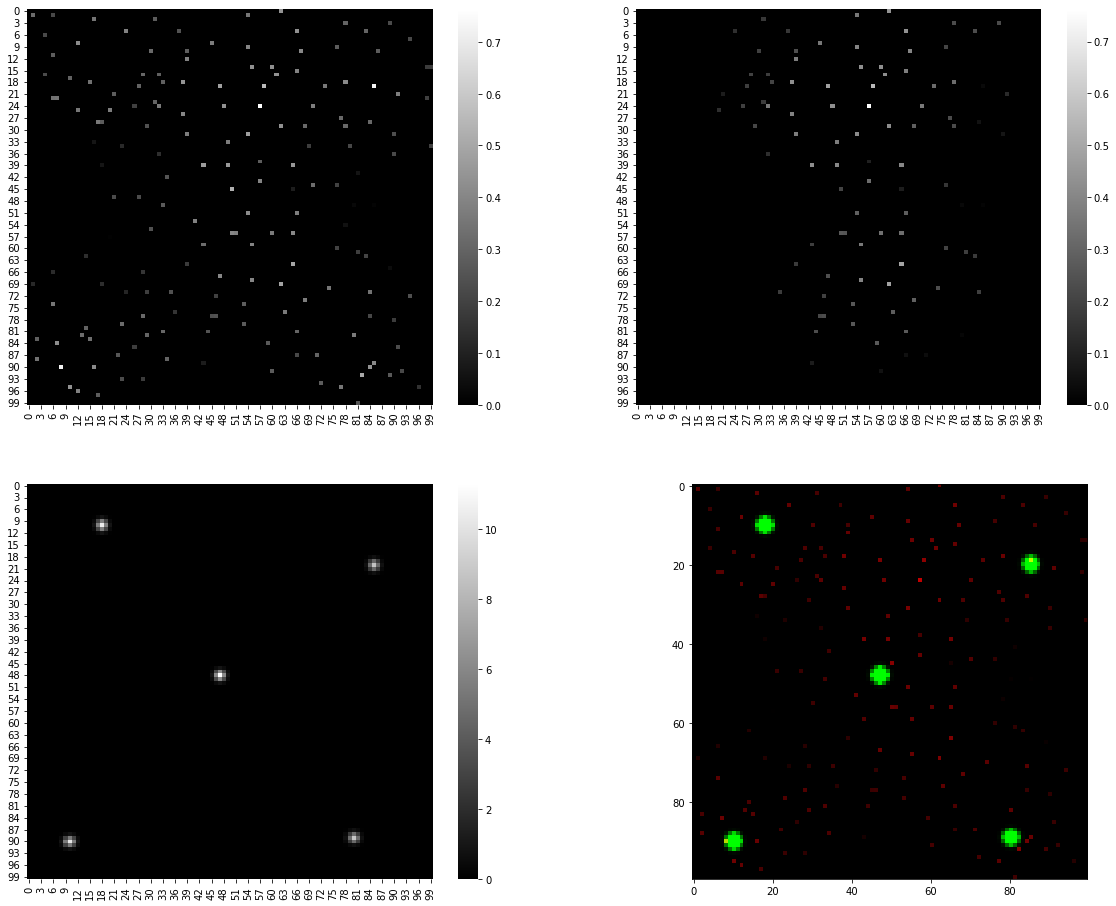

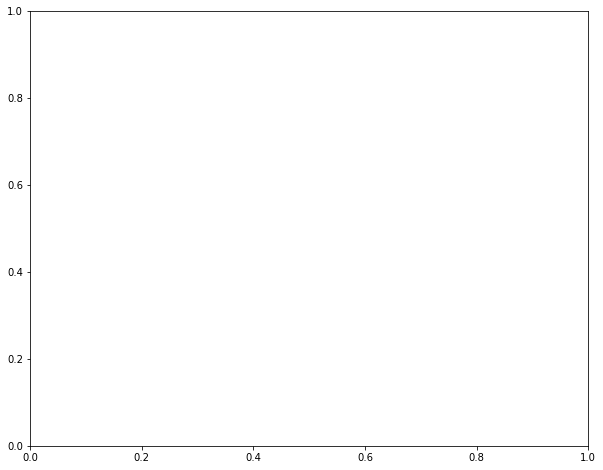

In [5]:
# i = 2024
# i = 2028
i = 10355
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
sns.heatmap(sensor_input_test_dataset[i]['matrix_auth'][0], cmap='gray', ax=axs.flat[0])
sns.heatmap(sensor_input_test_dataset[i]['matrix'][0], cmap='gray', ax=axs.flat[1])
sns.heatmap(sensor_input_test_dataset[i]['pu_matrix'][0], cmap='gray', ax=axs.flat[2])
zeros = np.zeros((100, 100))
tmp = np.stack((sensor_input_test_dataset[i]['two_sheet'][0], sensor_input_test_dataset[i]['two_sheet'][1], zeros), axis=2)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
axs.flat[3].imshow(tmp)
print('intruder\n', sensor_input_test_dataset[i]['target_float'])
print('authorized\n', sensor_input_test_dataset[i]['target_auth_float'])

In [ ]:
# training

root_dir = './data/305train'
sensor_input_dataset = SensorInputDatasetTranslation(root_dir=root_dir, transform=tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=False, num_workers=1, collate_fn=my_collate)

images_dir = '/home/caitao/Project/PyTorch-YOLOv3/data/deepmtl-305/images/train'
labels_dir = '/home/caitao/Project/PyTorch-YOLOv3/data/deepmtl-305/labels/train'
list_path  = '/home/caitao/Project/PyTorch-YOLOv3/data/deepmtl-305/train.txt'

device = torch.device('cuda')
# path5 = 'model/model1-12.8-net5-norm-32.pt'
path5 = 'model/model1-12.13-net5-norm-32-splat.pt'
model5_f5_norm = NetTranslation5_norm()
model5_f5_norm.load_state_dict(torch.load(path5))
model5_f5_norm = model5_f5_norm.to(device)
model5_f5_norm.eval()


with open(list_path, 'w') as f:
    for t, sample in enumerate(sensor_input_dataloader):
        if t % 10 == 9:
            print(t, end=' ')
        X = sample['matrix'].to(device)
        indx = sample['index']
        pred_matrix = model5_f5_norm(X)
        for idx, matrix in zip(indx, pred_matrix):
            idx = idx.data.cpu().numpy()
            matrix = matrix.data.cpu().numpy()
            image_name = sensor_input_dataset.save_object_detection_image(images_dir, matrix[0], idx)
            sensor_input_dataset.save_object_detection_label(labels_dir, idx, Default.grid_length, matrix[0])
            path = os.path.join(images_dir, image_name) + '.npy'
            f.write(path + '\n')


# testing or valid

root_dir = './data/305test'
sensor_input_test_dataset = SensorInputDatasetTranslation(root_dir=root_dir, transform=tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=False, num_workers=1, collate_fn=my_collate)

images_dir  = '/home/caitao/Project/PyTorch-YOLOv3/data/deepmtl-305/images/val'
labels_dir  = '/home/caitao/Project/PyTorch-YOLOv3/data/deepmtl-305/labels/val'
list_path   = '/home/caitao/Project/PyTorch-YOLOv3/data/deepmtl-305/valid.txt'

with open(list_path, 'w') as f:
    for t, sample in enumerate(sensor_input_test_dataloader):
        if t % 10 == 9:
            print(t, end=' ')
        X = sample['matrix'].to(device)
        indx = sample['index']
        pred_matrix = model5_f5_norm(X)
        for idx, matrix in zip(indx, pred_matrix):
            idx = idx.data.cpu().numpy()
            matrix = matrix.data.cpu().numpy()
            image_name = sensor_input_test_dataset.save_object_detection_image(images_dir, matrix[0], idx)
            sensor_input_test_dataset.save_object_detection_label(labels_dir, idx, Default.grid_length, matrix[0])
            path = os.path.join(images_dir, image_name) + '.npy'
            f.write(path + '\n')

# 3 Model

NetTranslation1: https://nbviewer.jupyter.org/github/caitaozhan/deeplearning-localization/blob/a33c3beb435228c025b85c53ccf9257d5be6ae08/CNN-translation-multi.ipynb, three layers, groupnorm seems not helping

NetTranslation2:
https://nbviewer.jupyter.org/github/caitaozhan/deeplearning-localization/blob/2f65a0590994cb90b89ab0662ceda58c31253e55/CNN-translation-multi2.ipynb, 
Concatinating image translation and number of TX

NetTranslation3: https://nbviewer.jupyter.org/github/caitaozhan/deeplearning-localization/blob/34a4c8444806b75d89a4b64bc66e122c27c193db/CNN-translation-multi-min-dist-upbound.ipynb, increase filter size from 5 to 7

NetTranslation4: remove the "second CNN", a pure image-to-image translation

NetTranslation5: Add a layer so that it looks symmetric (the BEST)

NetTranslation6: incorporate U-Net ideas, i.e. first down sample and then upsample

NetTranslation7: incorporate U-Net ideas, i.e. first down sample and then upsample, add skip layers

In [8]:
class SubtractNet(nn.Module):
    '''The chosen one!
       Image translation. Comparing with version 4, it adds a layer so it is symetric, it also has group normalization
       the first CNN is the same as NetTranslation, 
       the second one uses the output of the first CNN and output the # of Tx
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(SubtractNet, self).__init__()
        self.conv1 = nn.Conv2d(2,  8,  5, padding=2)   # TUNE: a larger filter decrease miss, decrease localization error
        self.conv2 = nn.Conv2d(8,  32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 8,  5, padding=2)
        self.conv4 = nn.Conv2d(8,  1,  5, padding=2)
        self.norm1 = nn.GroupNorm(4,  8)
        self.norm2 = nn.GroupNorm(16, 32)
        self.norm3 = nn.GroupNorm(4,  8)

    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        y = self.conv4(x)
        return y


net = SubtractNet()
print(net)

SubtractNet(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(8, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm1): GroupNorm(4, 8, eps=1e-05, affine=True)
  (norm2): GroupNorm(16, 32, eps=1e-05, affine=True)
  (norm3): GroupNorm(4, 8, eps=1e-05, affine=True)
)


In [114]:
class SubtractNet2(nn.Module):
    '''The chosen one!
       Image translation. Comparing with version 4, it adds a layer so it is symetric, it also has group normalization
       the first CNN is the same as NetTranslation, 
       the second one uses the output of the first CNN and output the # of Tx
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(SubtractNet2, self).__init__()
        self.conv1 = nn.Conv2d(2,  8,  5, padding=2)   # TUNE: a larger filter decrease miss, decrease localization error
        self.conv2 = nn.Conv2d(8,  16, 5, padding=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 16, 5, padding=2)
        self.conv5 = nn.Conv2d(16, 8,  5, padding=2)
        self.conv6 = nn.Conv2d(8,  1,  5, padding=2)
        self.norm1 = nn.GroupNorm(4,  8)
        self.norm2 = nn.GroupNorm(8,  16)
        self.norm3 = nn.GroupNorm(16, 32)
        self.norm4 = nn.GroupNorm(8,  16)
        self.norm5 = nn.GroupNorm(4,  8)

    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        x = F.relu(self.norm4(self.conv4(x)))
        x = F.relu(self.norm5(self.conv5(x)))
        y = self.conv6(x)
        return y


net = SubtractNet2()
print(net)

SubtractNet2(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(8, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm1): GroupNorm(4, 8, eps=1e-05, affine=True)
  (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (norm3): GroupNorm(16, 32, eps=1e-05, affine=True)
  (norm4): GroupNorm(8, 16, eps=1e-05, affine=True)
  (norm5): GroupNorm(4, 8, eps=1e-05, affine=True)
)


In [6]:
class SubtractNet3(nn.Module):
    '''The chosen one!
       Image translation. Comparing with version 4, it adds a layer so it is symetric, it also has group normalization
       the first CNN is the same as NetTranslation, 
       the second one uses the output of the first CNN and output the # of Tx
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(SubtractNet3, self).__init__()
        self.conv1 = nn.Conv2d(2,  8,  5, padding=2)   # TUNE: a larger filter decrease miss, decrease localization error
        self.conv2 = nn.Conv2d(8,  16, 5, padding=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 5, padding=2)
        self.conv5 = nn.Conv2d(32, 16, 5, padding=2)
        self.conv6 = nn.Conv2d(16, 8,  5, padding=2)
        self.conv7 = nn.Conv2d(8,  2,  5, padding=2)
        self.conv8 = nn.Conv2d(2,  1,  5, padding=2)
        self.norm1 = nn.GroupNorm(4,  8)
        self.norm2 = nn.GroupNorm(8,  16)
        self.norm3 = nn.GroupNorm(16, 32)
        self.norm4 = nn.GroupNorm(16, 32)
        self.norm5 = nn.GroupNorm(8, 16)
        self.norm6 = nn.GroupNorm(4,  8)
        self.norm7 = nn.GroupNorm(1,  2)

    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        x = F.relu(self.norm4(self.conv4(x)))
        x = F.relu(self.norm5(self.conv5(x)))
        x = F.relu(self.norm6(self.conv6(x)))
        x = F.relu(self.norm7(self.conv7(x)))
        y = self.conv8(x)
        return y


net = SubtractNet3()
print(net)

SubtractNet3(
  (conv1): Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv7): Conv2d(8, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv8): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm1): GroupNorm(4, 8, eps=1e-05, affine=True)
  (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (norm3): GroupNorm(16, 32, eps=1e-05, affine=True)
  (norm4): GroupNorm(16, 32, eps=1e-05, affine=True)
  (norm5): GroupNorm(8, 16, eps=1e-05, affine=True)
  (norm6): GroupNorm(4, 8, eps=1e-05, affine=True)
  (norm7): GroupNorm(1, 2, eps=1e-05, affine=True)
)


In [12]:
class NetTranslation5_norm(nn.Module):
    '''The chosen one!
       Image translation. Comparing with version 4, it adds a layer so it is symetric, it also has group normalization
       the first CNN is the same as NetTranslation, 
       the second one uses the output of the first CNN and output the # of Tx
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(NetTranslation5_norm, self).__init__()
        self.conv1 = nn.Conv2d(1,  8,  5, padding=2)   # TUNE: a larger filter decrease miss, decrease localization error
        self.conv2 = nn.Conv2d(8,  32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 8,  5, padding=2)
        self.conv4 = nn.Conv2d(8,  1,  5, padding=2)
        self.norm1 = nn.GroupNorm(4,  8)
        self.norm2 = nn.GroupNorm(16, 32)
        self.norm3 = nn.GroupNorm(4,  8)

    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        y = self.conv4(x)
        return y


net = NetTranslation5_norm()
print(net)

NetTranslation5_norm(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(8, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm1): GroupNorm(4, 8, eps=1e-05, affine=True)
  (norm2): GroupNorm(16, 32, eps=1e-05, affine=True)
  (norm3): GroupNorm(4, 8, eps=1e-05, affine=True)
)


# Training

## Train Substract Power Only

train loss of image translation = 0.0001381280854401565
test  loss of image translation = 0.00024898435760607957


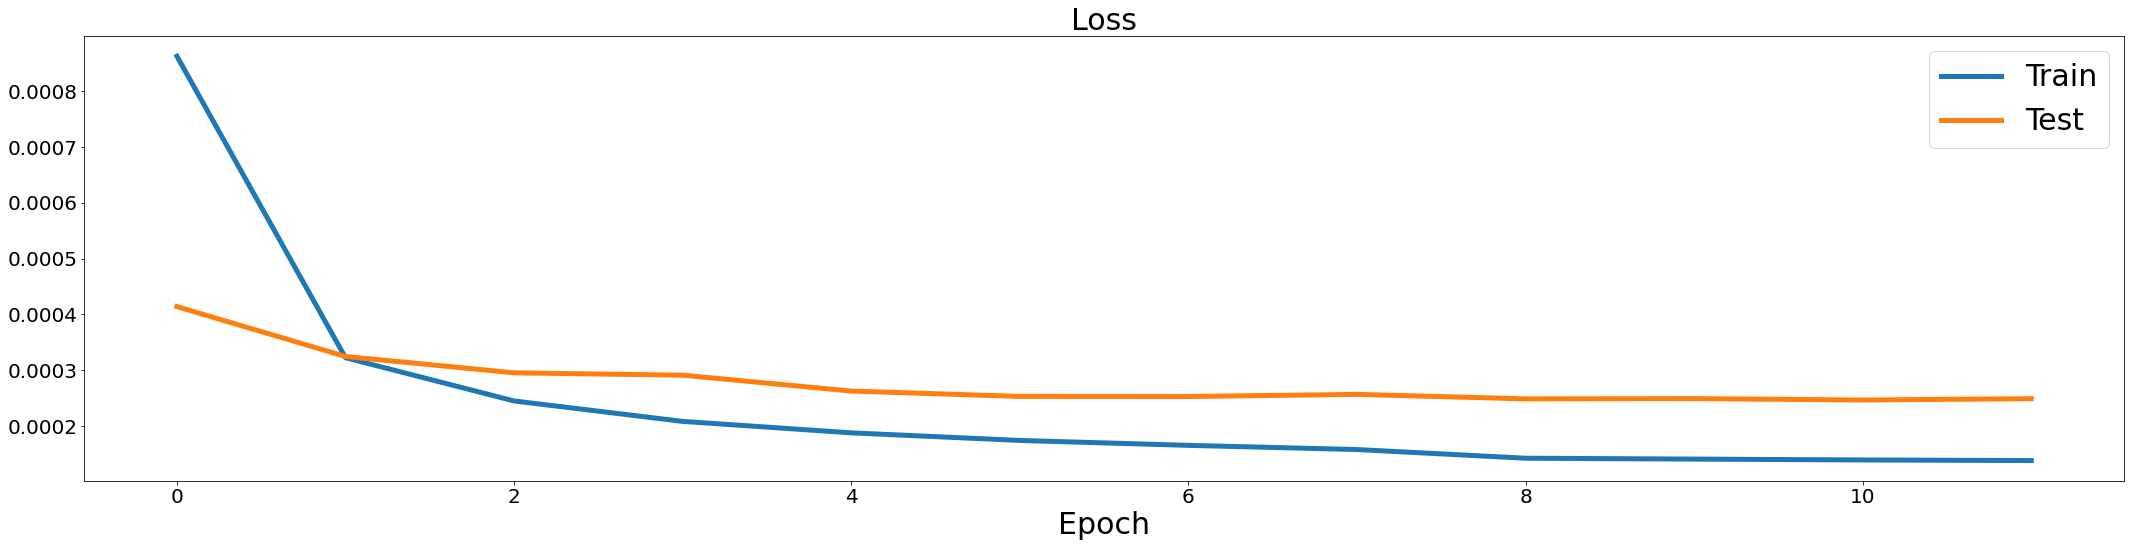

In [128]:
# %%time
# image translation problem
device = torch.device('cuda')

model1 = SubtractNet3()
path1 = 'model/subtractnet3-10.7-pu_guassian.pt'

model1_minloss = 1000
model1 = model1.to(device)
optimizer1 = optim.Adam(model1.parameters(), lr = 0.001) #, weight_decay=0.0001''')
mse_loss   = nn.MSELoss()  # criterion is the loss function
scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=8, gamma=0.1)

num_epochs = 12
train_losses1_epoch = []
test_losses1_epoch  = []
print_every = 200
# zeros  = make_zeros(batch=32, length=100)
# alpha  = 0    # control regulation

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses1 = []
    test_losses1 = []
    model1.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['two_sheet'].to(device)
        y = sample['matrix'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix = model1(X)              # the model for iamge translation
        loss_matrix = mse_loss(pred_matrix, y)
        loss1 = loss_matrix
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        train_losses1.append(loss1.item())
        pred_matrix = pred_matrix.data.cpu().numpy()
        if t % print_every == 0:
            print(f't = {t}, loss_matrix = {loss_matrix.item()}') #, regulation = {regulation.item()}')

    model1.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['two_sheet'].to(device)
        y = sample['matrix'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix = model1(X)              # the model for iamge translation
        loss_matrix = mse_loss(pred_matrix, y)
#         regulation  = l1_loss(pred_matrix, zeros)
        loss1 = loss_matrix # + alpha*regulation

        test_losses1.append(loss1.item())
        pred_matrix = pred_matrix.data.cpu().numpy()

    if np.mean(test_losses1) < model1_minloss:
        torch.save(model1.state_dict(), path1.format('best'))
        model1_minloss = np.mean(test_losses1)

    torch.save(model1.state_dict(), path1.format(epoch))

    scheduler1.step()
    clear_output(True)
    train_losses1_epoch.append(np.mean(train_losses1))
    test_losses1_epoch.append(np.mean(test_losses1))
    print('train loss of image translation =', train_losses1_epoch[-1])
    print('test  loss of image translation =', test_losses1_epoch[-1])
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 1, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses1_epoch, label='Train', linewidth=5)
    plt.plot(test_losses1_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

In [129]:
test_losses1_epoch

[0.00041384282394574257,
 0.00032456422450195533,
 0.0002952711886892858,
 0.00029106603548522493,
 0.00026262874194395006,
 0.00025305542554229354,
 0.0002528731733744078,
 0.00025669987323150657,
 0.00024864669895679174,
 0.00024911685489617714,
 0.0002466115459558043,
 0.00024898435760607957]

## Train SubtractNet while translating to peaks

train loss of image translation = 0.046765335459753664
test  loss of image translation = 0.04858438124776714
train error = 0.8776887562572199
test error  = 0.8649868596881959
train miss = 0.027704979408461252
test  miss = 0.03023758099352052
train false = 0.023212280044926994
test  false = 0.023038156947444204


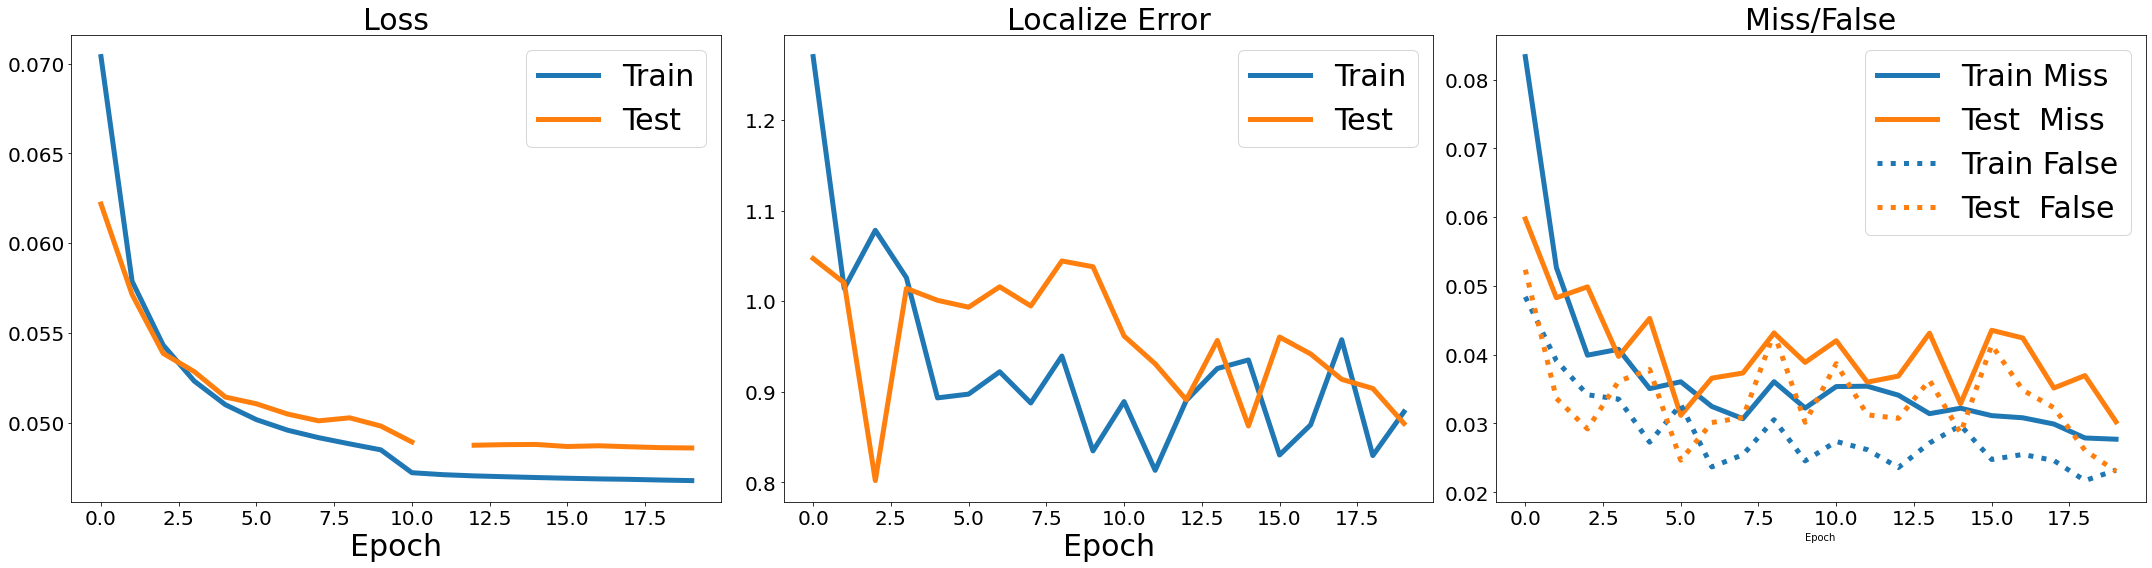

In [9]:
# %%time
# image translation problem
device     = torch.device('cuda')

model1 = SubstractNet()
path1 = 'model/subtractnet-10.6.pt'

model1_minloss = 1000
model1 = model1.to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)#, weight_decay=0.0001''')
mse_loss   = nn.MSELoss()  # criterion is the loss function
l1_loss    = nn.L1Loss()
scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.1)

num_epochs = 20
train_losses1_epoch, train_errors1_epoch, train_misses1_epoch, train_falses1_epoch = [], [], [], []
test_losses1_epoch,  test_errors1_epoch,  test_misses1_epoch,  test_falses1_epoch  = [], [], [], []
print_every, error_every = 200, 200
# zeros  = make_zeros(batch=32, length=100)
# alpha  = 0    # control regulation

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses1, train_errors1, train_misses1, train_falses1 = [], [], [], []
    test_losses1,  test_errors1,  test_misses1,  test_falses1  = [], [], [], []
    train_numtx, test_numtx = 0, 0
    model1.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix = model1(X)              # the model for iamge translation
        loss_matrix = mse_loss(pred_matrix, y)
#         regulation  = l1_loss(pred_matrix, zeros)
        loss1 = loss_matrix # + alpha * regulation
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        train_losses1.append(loss1.item())
        pred_matrix = pred_matrix.data.cpu().numpy()
        if t % error_every == 0:
            errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, y_num2, y_float, indx, Default.grid_length, 1)
            train_errors1.extend(errors)
            train_misses1.extend(misses)
            train_falses1.extend(falses)
            train_numtx += y_num2.sum()
        if t % print_every == 0:
            print(f't = {t}, loss_matrix = {loss_matrix.item()}') #, regulation = {regulation.item()}')

    model1.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix = model1(X)              # the model for iamge translation
        loss_matrix = mse_loss(pred_matrix, y)
#         regulation  = l1_loss(pred_matrix, zeros)
        loss1 = loss_matrix # + alpha*regulation

        test_losses1.append(loss1.item())
        pred_matrix = pred_matrix.data.cpu().numpy()
        if t % error_every == 0:
            errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, y_num2, y_float, indx, Default.grid_length, 1)
            test_errors1.extend(errors)
            test_misses1.extend(misses)
            test_falses1.extend(falses)
            test_numtx += y_num2.sum()

    if np.mean(test_losses1) < model1_minloss:
        torch.save(model1.state_dict(), path1.format('best'))
        model1_minloss = np.mean(test_losses1)

    torch.save(model1.state_dict(), path1.format(epoch))


    scheduler1.step()
    clear_output(True)
    train_losses1_epoch.append(np.mean(train_losses1))
    test_losses1_epoch.append(np.mean(test_losses1))
    train_errors1 = [val for sublist in train_errors1 for val in sublist]  # flatten a 2D matrix
    test_errors1  = [val for sublist in test_errors1 for val in sublist]   # flatten a 2D matrix
    train_errors1_epoch.append(np.mean(train_errors1))
    test_errors1_epoch.append(np.mean(test_errors1))
    train_misses1_epoch.append(np.sum(train_misses1) / train_numtx)
    test_misses1_epoch.append(np.sum(test_misses1)   / test_numtx)
    train_falses1_epoch.append(np.sum(train_falses1) / train_numtx)
    test_falses1_epoch.append(np.sum(test_falses1)   / test_numtx)
    print('train loss of image translation =', train_losses1_epoch[-1])
    print('test  loss of image translation =', test_losses1_epoch[-1])
    print('train error =', train_errors1_epoch[-1])
    print('test error  =', test_errors1_epoch[-1])
    print('train miss =', train_misses1_epoch[-1])
    print('test  miss =', test_misses1_epoch[-1])
    print('train false =', train_falses1_epoch[-1])
    print('test  false =', test_falses1_epoch[-1])
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 3, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses1_epoch, label='Train', linewidth=5)
    plt.plot(test_losses1_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.subplot(1, 3, 2)
    plt.title('Localize Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_errors1_epoch, label='Train', linewidth=5)
    plt.plot(test_errors1_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.subplot(1, 3, 3)
    plt.title('Miss/False', fontsize=30)
    plt.xlabel('Epoch')
    plt.plot(train_misses1_epoch, label='Train Miss',  linewidth=5, linestyle='-', color='#1f77b4')
    plt.plot(test_misses1_epoch,  label='Test  Miss',  linewidth=5, linestyle='-', color='#ff7f0e')
    plt.plot(train_falses1_epoch, label='Train False', linewidth=5, linestyle=':', color='#1f77b4')
    plt.plot(test_falses1_epoch,  label='Test  False', linewidth=5, linestyle=':', color='#ff7f0e')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

# Evaluation

## Compare different image translation models

intruders [[[ 8.679017 84.29895 ]]]
authorized [[[14.823299 10.443237]
  [20.742311 89.12258 ]
  [50.581867 48.718327]
  [85.3081   18.071917]
  [87.47415  85.33456 ]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


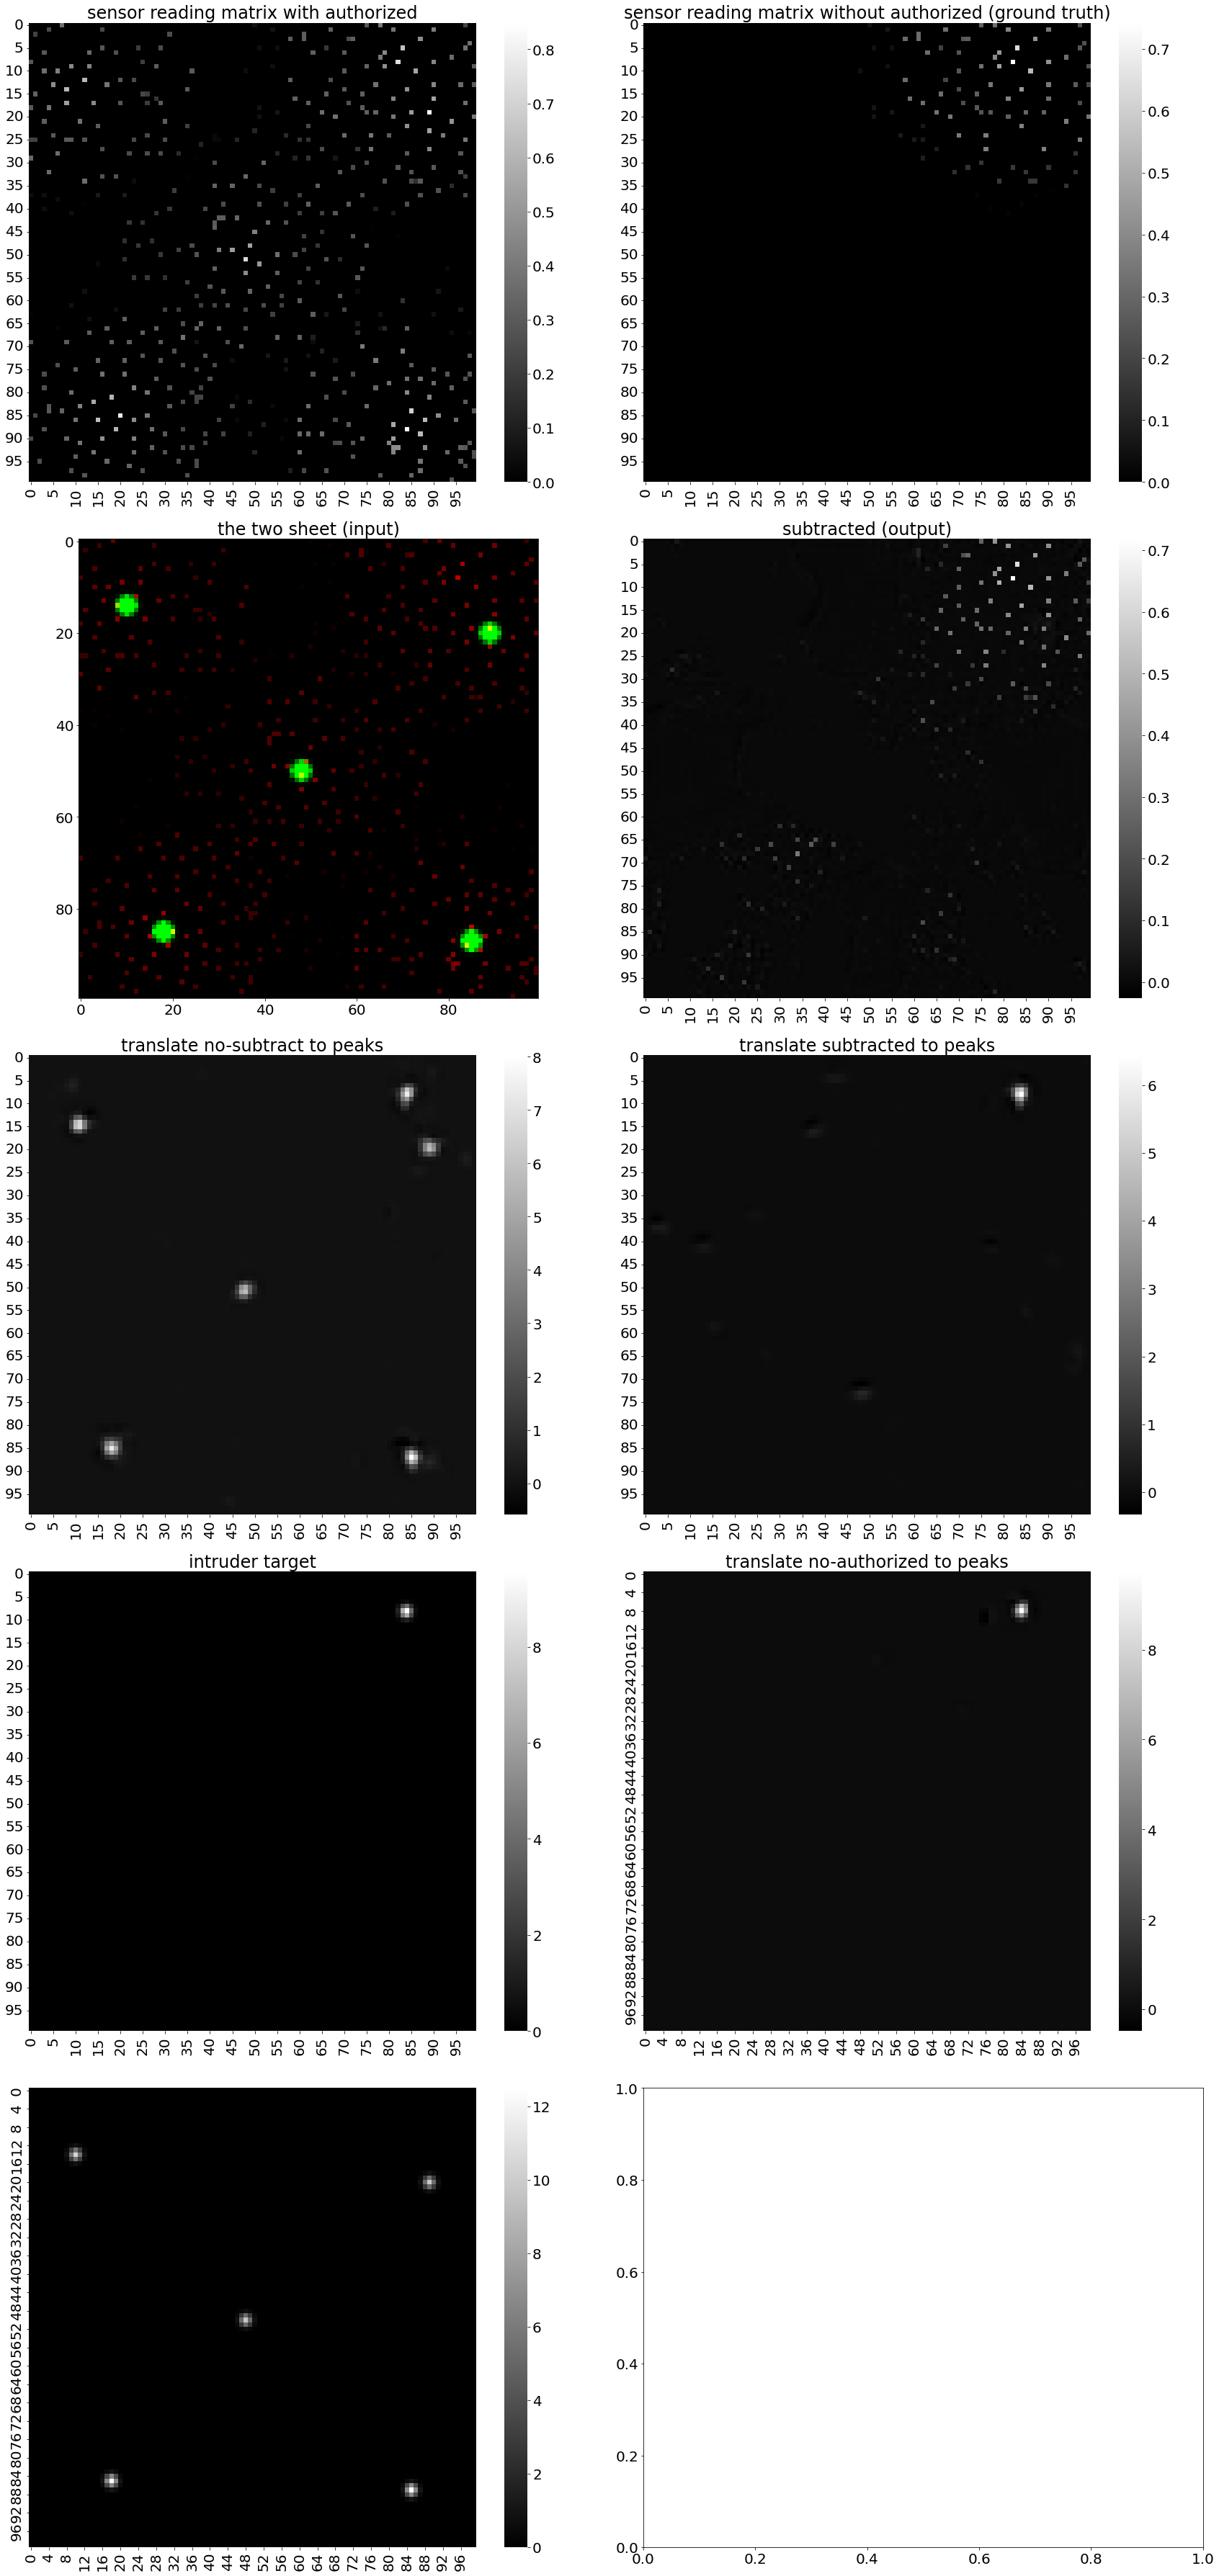

In [22]:
device = torch.device('cuda')

path = 'model/subtractnet3-10.7-pu_guassian.pt'
subtract_net = SubtractNet3()
subtract_net.load_state_dict(torch.load(path))
subtract_net = subtract_net.to(device)
subtract_net.eval()

path5 = 'model/model1-12.13-net5-norm-32-splat.pt'
model5 = NetTranslation5_norm()
model5.load_state_dict(torch.load(path5))
model5 = model5.to(device)
model5.eval()

criterion1 = nn.MSELoss()

# idx = 3857    # three TX close to each other
# idx = 6567  # three TX close to each other
idx = 29682
idx = 29747
idx = 34627
idx = 29072
idx = 3292

global_pred_matrix          = None
global_pred_matrix_auth     = None
global_pred_matrix_subtract = None


def one_sample3(idx):
    '''used for observing authorized user subtraction
    '''
    device = torch.device('cuda')
    sample = sensor_input_test_dataset[idx]
#     sample = sensor_input_dataset[idx]
    X = torch.as_tensor(sample['two_sheet'])
    X = X.unsqueeze(0).to(device)            # increase dimension to a batch
    y = torch.as_tensor(sample['target'])
    y = y.unsqueeze(0).to(device)            # increase dimension to a batch
    y_num = torch.as_tensor(sample['target_num'])
    y_num = y_num.unsqueeze(0).to(device)    # increase dimension to a batch
    y_f = np.expand_dims(sample['target_float'], 0)
    y_auth = np.expand_dims(sample['target_auth_float'], 0)
    indx = np.expand_dims(np.array(sample['index']), 0)
    X_auth = torch.as_tensor(sample['matrix_auth'])
    X_auth = X_auth.unsqueeze(0).to(device)
    print('intruders', y_f)
    print('authorized', y_auth)
    fig, axs = plt.subplots(5, 2, figsize=(24, 50))
    plt.rcParams['font.size'] = 20
    
    # 0: sensor reading matrix with authorized users
    sns.heatmap(sample['matrix_auth'][0], cmap='gray', ax=axs.flat[0])
    axs.flat[0].set_title('sensor reading matrix with authorized')
    # 1: sensor reading matrix without authorized users
    sns.heatmap(sample['matrix'][0], cmap='gray', ax=axs.flat[1])
    axs.flat[1].set_title('sensor reading matrix without authorized (ground truth)')
    # 2: the two sheet
    sheet_one = X.data.cpu().numpy()[0][0]
    sheet_two = X.data.cpu().numpy()[0][1]
    zeros = np.zeros((100, 100))
    img = np.stack((sheet_one, sheet_two, zeros), axis=2)
    axs.flat[2].imshow(img)    
    axs.flat[2].set_title('the two sheet (input)')
    # 3: subtraction of the two sheet
    pred_matrix = subtract_net(X)
    translate_subtract = model5(pred_matrix)
    pred_matrix = pred_matrix[0][0].data.cpu().numpy()
    sns.heatmap(pred_matrix, cmap='gray', ax=axs.flat[3])
    axs.flat[3].set_title('subtracted (output)')
    # 4: translation of the no-subtract
    matrix_auth = torch.as_tensor(sample['matrix_auth'])
    matrix_auth = matrix_auth.unsqueeze(0).to(device)
    pred_matrix = model5(matrix_auth)
    pred_matrix = pred_matrix[0][0].data.cpu().numpy()
    global global_pred_matrix_auth
    global_pred_matrix_auth = pred_matrix
    sns.heatmap(pred_matrix, cmap='gray', ax=axs.flat[4])
    axs.flat[4].set_title('translate no-subtract to peaks')
    # 5: translation of the subtracted
    translate_subtract = translate_subtract[0][0].data.cpu().numpy()
    global global_pred_matrix_subtract
    global_pred_matrix_subtract = translate_subtract
    sns.heatmap(translate_subtract, cmap='gray', ax=axs.flat[5])
    axs.flat[5].set_title('translate subtracted to peaks')
    # 6: the intruders
    sns.heatmap(y[0][0].data.cpu().numpy(), cmap='gray', ax=axs.flat[6])
    axs.flat[6].set_title('intruder target')
    fig.tight_layout()
    # 7: translate no-authorized sensor reading input matrix
    matrix = torch.as_tensor(sample['matrix'])
    matrix = matrix.unsqueeze(0).to(device)
    pred_matrix = model5(matrix)
    pred_matrix = pred_matrix[0][0].data.cpu().numpy()
    global global_pred_matrix
    global_pred_matrix = pred_matrix
    sns.heatmap(pred_matrix, cmap='gray', ax=axs.flat[7])
    axs.flat[7].set_title('translate no-authorized to peaks')
    # 8: PU matrix
    matrix = sample['pu_matrix']
    sns.heatmap(matrix[0], cmap='gray', ax=axs.flat[8])


one_sample3(idx)

In [23]:
img = np.stack((global_pred_matrix, global_pred_matrix, global_pred_matrix), axis=2)
path = f'../PyTorch-YOLOv3/data/authorized/{idx}.npy'
np.save(path, img.astype(np.float32))

img = np.stack((global_pred_matrix_auth, global_pred_matrix_auth, global_pred_matrix_auth), axis=2)
path = f'../PyTorch-YOLOv3/data/authorized/{idx}auth.npy'
np.save(path, img.astype(np.float32))

img = np.stack((global_pred_matrix_subtract, global_pred_matrix_subtract, global_pred_matrix_subtract), axis=2)
path = f'../PyTorch-YOLOv3/data/authorized/{idx}subtract.npy'
np.save(path, img.astype(np.float32))

Text(0.5, 1.0, 'sensor reading matrix with authorized')

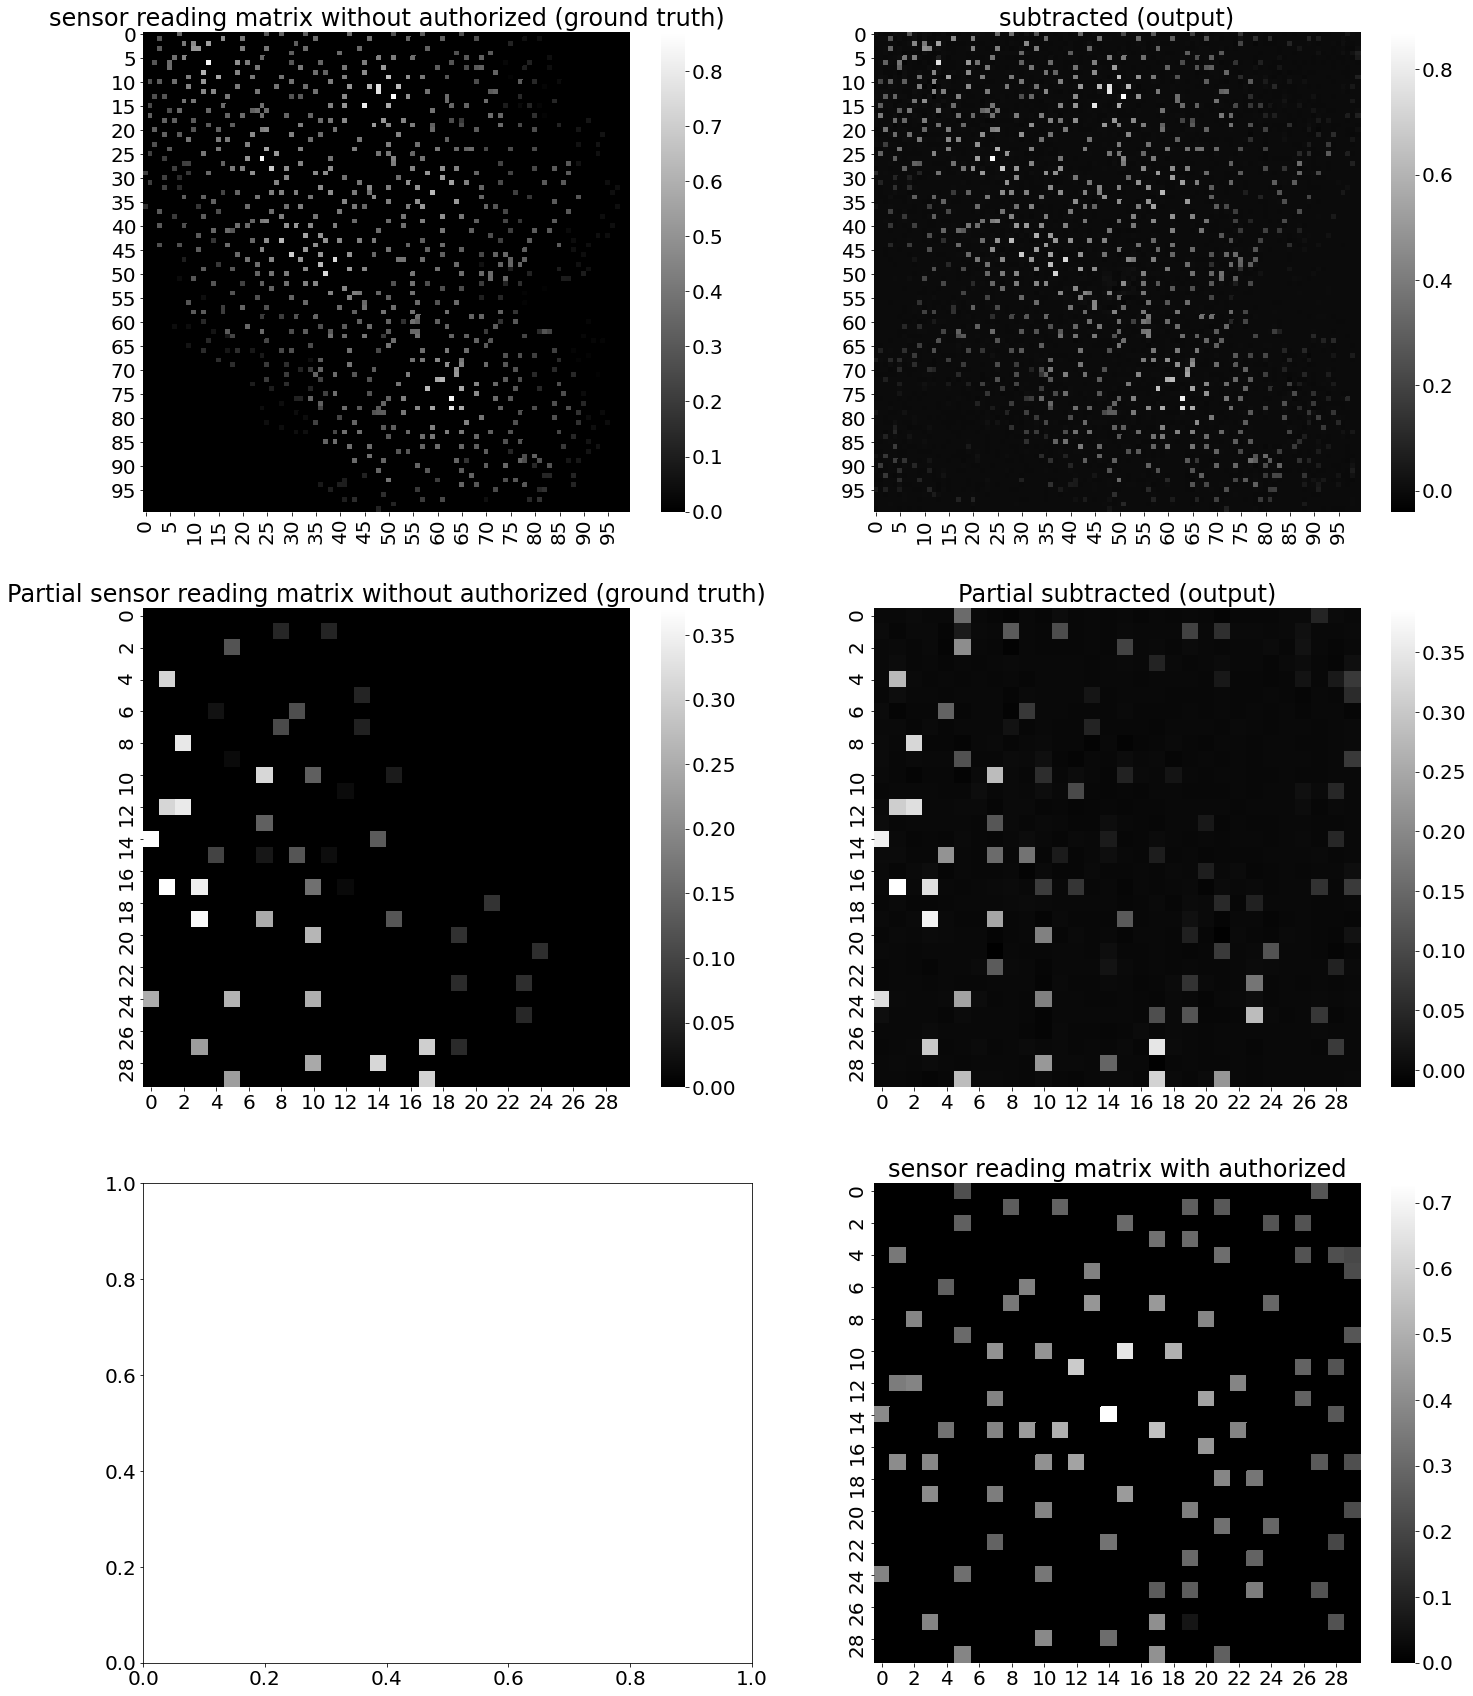

In [126]:
# sample = sensor_input_test_dataset[idx]
sample = sensor_input_test_dataset[idx]
X = torch.as_tensor(sample['two_sheet'])
X = X.unsqueeze(0).to(device)            # increase dimension to a batch

fig, axs = plt.subplots(3, 2, figsize=(24, 30))

# 0: sensor reading matrix without authorized users
sns.heatmap(sample['matrix'][0], cmap='gray', ax=axs.flat[0])
axs.flat[0].set_title('sensor reading matrix without authorized (ground truth)')
# 1: subtraction of the two sheet
pred_matrix = subtract_net(X)
translate_subtract = model5(pred_matrix)
pred_matrix = pred_matrix[0][0].data.cpu().numpy()
sns.heatmap(pred_matrix, cmap='gray', ax=axs.flat[1])
axs.flat[1].set_title('subtracted (output)')

# 2: part of ground truth
a, b, c, d = 0, 30, 70, 100
sns.heatmap(sample['matrix'][0][a:b, c:d], cmap='gray', ax=axs.flat[2])
axs.flat[2].set_title('Partial sensor reading matrix without authorized (ground truth)')
# 3: part of the subtracted output
sns.heatmap(pred_matrix[a:b, c:d], cmap='gray', ax=axs.flat[3])
axs.flat[3].set_title('Partial subtracted (output)')
# 3: part of sensor reading matrix with authorized
sns.heatmap(sample['matrix_auth'][0][a:b, c:d], cmap='gray', ax=axs.flat[5])
axs.flat[5].set_title('sensor reading matrix with authorized')

intruders [[[86.768524 21.548357]]]
authorized [[[ 9.082861  10.966305 ]
  [12.110846  96.29166  ]
  [45.22847   50.110004 ]
  [95.86526    7.5516667]
  [89.500755  90.028725 ]]]
indruder loss matrix = 0.004378733225166798


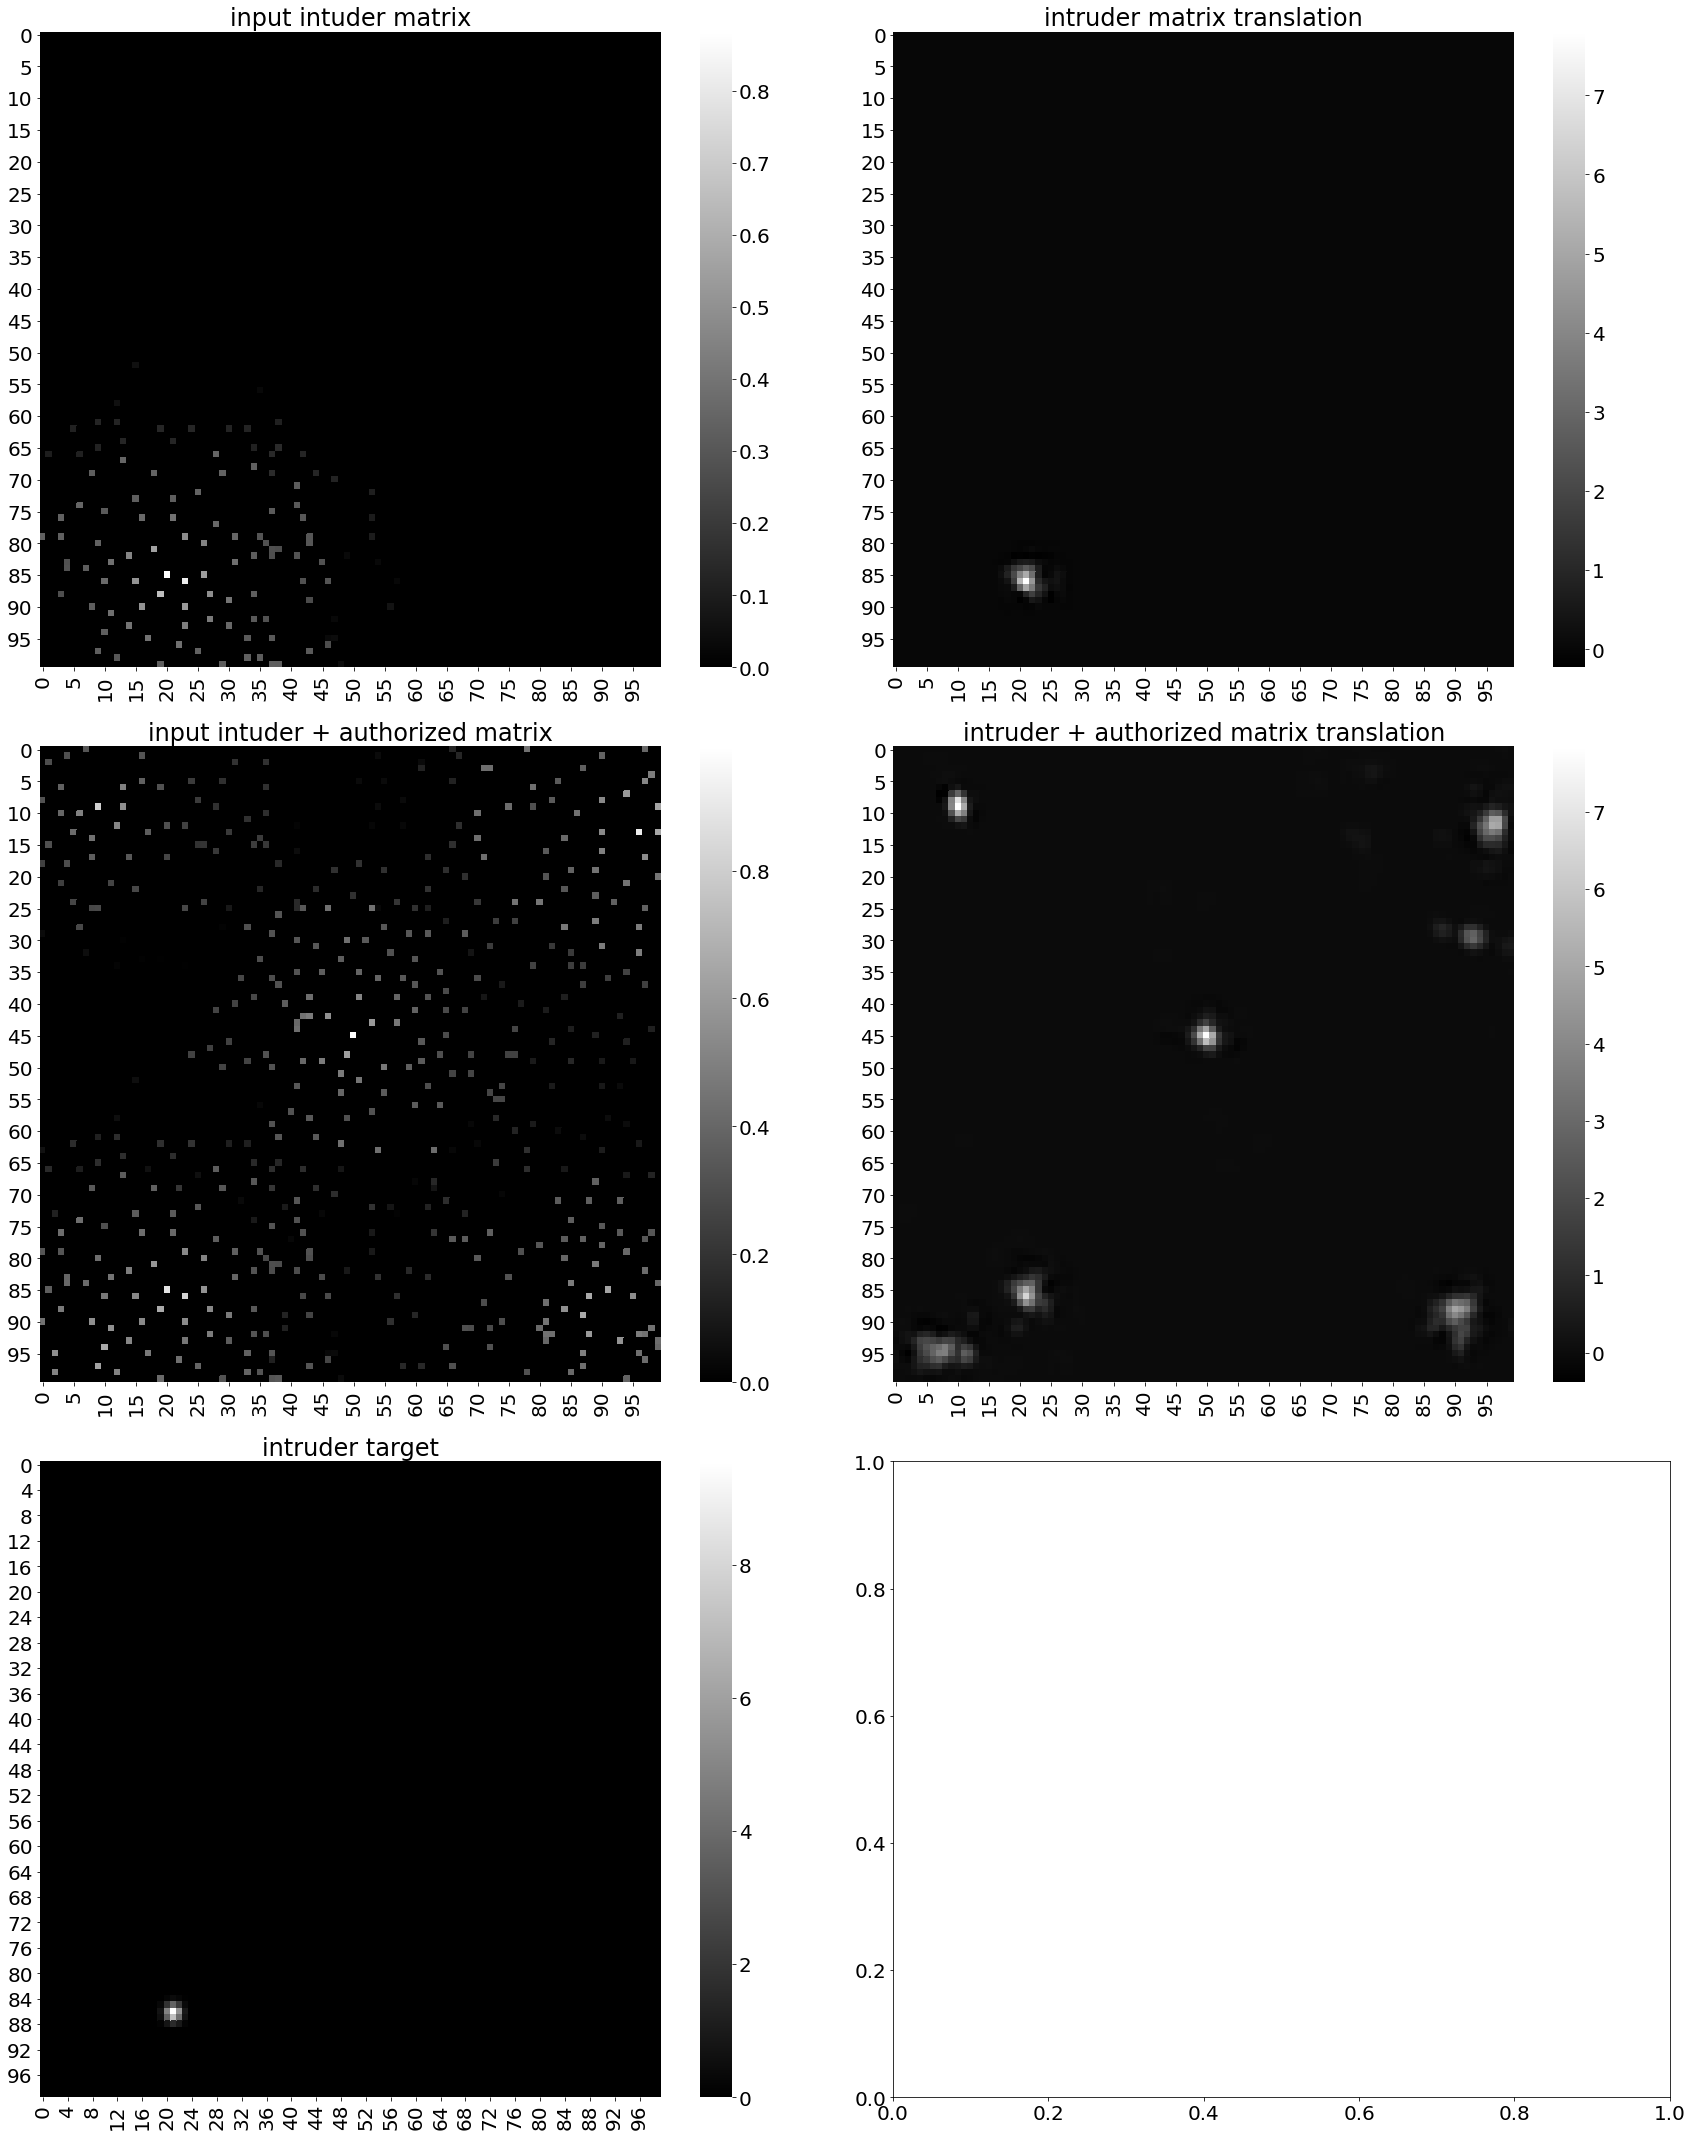

In [42]:
device = torch.device('cuda')

path5 = 'model/model1-12.13-net5-norm-32-splat.pt'
model5 = NetTranslation5_norm()
model5.load_state_dict(torch.load(path5))
model5 = model5.to(device)
model5.eval()

criterion1 = nn.MSELoss()

idx = 40417    # three TX close to each other

global_pred_matrix     = None
global_pred_matrix_auth = None

def one_sample2(idx):
    '''used for comparing different image translation models
    '''
    device = torch.device('cuda')
    sample = sensor_input_test_dataset[idx]
    X = torch.as_tensor(sample['matrix'])
    X = X.unsqueeze(0).to(device)            # increase dimension to a batch
    y = torch.as_tensor(sample['target'])
    y = y.unsqueeze(0).to(device)            # increase dimension to a batch
    y_num = torch.as_tensor(sample['target_num'])
    y_num = y_num.unsqueeze(0).to(device)    # increase dimension to a batch
    y_f = np.expand_dims(sample['target_float'], 0)
    y_auth = np.expand_dims(sample['target_auth_float'], 0)
    indx = np.expand_dims(np.array(sample['index']), 0)
    X_auth = torch.as_tensor(sample['matrix_auth'])
    X_auth = X_auth.unsqueeze(0).to(device)
    print('intruders', y_f)
    print('authorized', y_auth)
    fig, axs = plt.subplots(3, 2, figsize=(24, 30))
    plt.rcParams['font.size'] = 20
    # 0: input intruder matrix
    sns.heatmap(X[0][0].data.cpu().numpy(), cmap='gray', ax=axs.flat[0])
    axs.flat[0].set_title('input intuder matrix')
    # 1: translate intruder matrix
    pred_matrix = model5(X)
    global global_pred_matrix
    global_pred_matrix = pred_matrix
    loss_matrix = criterion1(pred_matrix, y)
    print('indruder loss matrix =', loss_matrix.item())
    pred_matrix = pred_matrix[0][0].data.cpu().numpy()
    sns.heatmap(pred_matrix, cmap='gray', ax=axs.flat[1])
    axs.flat[1].set_title('intruder matrix translation')
    # 2: input intruder + authorized matrix
    sns.heatmap(X_auth[0][0].data.cpu().numpy(), cmap='gray', ax=axs.flat[2])
    axs.flat[2].set_title('input intuder + authorized matrix')
    # 3: translate of intruder + authorized
    pred_matrix = model5(X_auth)
    global global_pred_matrix_auth
    global_pred_matrix_auth = pred_matrix
    pred_matrix = pred_matrix[0][0].data.cpu().numpy()
    sns.heatmap(pred_matrix, cmap='gray', ax=axs.flat[3])
    axs.flat[3].set_title('intruder + authorized matrix translation')
    fig.tight_layout()
    # 4: target
    sns.heatmap(y[0][0].data.cpu().numpy(), cmap='gray', ax=axs.flat[4])
    axs.flat[4].set_title('intruder target')

one_sample2(idx)

In [43]:
global_pred_matrix = global_pred_matrix.data.cpu().numpy()[0][0]
img = np.stack((global_pred_matrix, global_pred_matrix, global_pred_matrix), axis=2)
path = '../PyTorch-YOLOv3/data/authorized/40417.npy'
np.save(path, img.astype(np.float32))

In [44]:
global_pred_matrix_auth = global_pred_matrix_auth.data.cpu().numpy()[0][0]
img = np.stack((global_pred_matrix_auth, global_pred_matrix_auth, global_pred_matrix_auth), axis=2)
path = '../PyTorch-YOLOv3/data/authorized/40417auth.npy'
np.save(path, img.astype(np.float32))

## Combine SubtractNet and TranslationNet

In [ ]:
device = torch.device('cuda')

path_subtract = 'model/subtractnet-10.7.pt'
subtract_net = SubtractNet()
subtract_net.load_state_dict(torch.load(path_subtract))
subtract_net = subtract_net.to(device)
subtract_net.eval()

path_translate = 'model/model1-12.13-net5-norm-32-splat.pt'
translate_net = NetTranslation5_norm()
translate_net.load_state_dict(torch.load(path_translate))
translate_net = translate_net.to(device)
translate_net.eval()

test_errors, test_misses, test_falses = [], [], []

for t, sample in enumerate(sensor_input_test_dataloader):
    if t % 10 == 0:
        print(t, end=' ')
    if t == 100:
        break
    X = sample['two_sheet'].to(device)
    X_subtract = subtract_net(X)
    pred_matrix = translate_net(X_subtract)
    
    y_num = np.array(sample['target_num'])
    y_float = my_uncollate(y_num, y_float)
    indx = sample['index']
    pred_matrix = pred_matrix.data.cpu().numpy()
    
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, y_num, y_float, indx, Default.grid_length, False)
    test_errors.extend(errors)
    test_misses.extend(misses)
    test_falses.extend(falses)

print('avg error', np.mean(test_errors))
print('avg miss', np.mean(test_misses))
print('agg false', np.mean(falses))

In [52]:
test_errors  = [val for sublist in test_errors for val in sublist]   # flatten a 2D matrix

In [54]:
np.mean(test_errors)

11.115210714285714

## Part of a figure in the paper

In [ ]:
# the plot in the paper

device = torch.device('cuda')

path5 = 'model/model1-12.3-net5-f5-norm.pt'
model5_f5_norm = NetTranslation5_norm()
model5_f5_norm.load_state_dict(torch.load(path5))
model5_f5_norm = model5_f5_norm.to(device)
model5_f5_norm.eval()

idx = 9179     # use this in the paper

def one_sample2(idx):
    '''used for comparing different image translation models
    '''
    device = torch.device('cuda')
    sample = sensor_input_test_dataset[idx]
    X = torch.as_tensor(sample['matrix'])
    X = X.unsqueeze(0).to(device)            # increase dimension to a batch
    y = torch.as_tensor(sample['target'])
    y = y.unsqueeze(0).to(device)            # increase dimension to a batch
    y_num = torch.as_tensor(sample['target_num'])
    y_num = y_num.unsqueeze(0).to(device)    # increase dimension to a batch
    y_f = np.expand_dims(sample['target_float'], 0)
    indx = np.expand_dims(np.array(sample['index']), 0)
    print('target', y_f)

    fig, axs = plt.subplots(3, 2, figsize=(23.5, 30))
    plt.rcParams['font.size'] = 20
    # input
    sns.heatmap(X[0][0].data.cpu().numpy(), cmap='gray', ax=axs.flat[0])
    axs.flat[0].set_title('input matrix')
    # target
    target = y[0][0].data.cpu().numpy()
    sns.heatmap(y[0][0].data.cpu().numpy(), cmap='gray', ax=axs.flat[1])
    axs.flat[1].set_title('target')
    # net5
    x1, x2, x3, y = model5_f5_norm(X)
    print('x1 shape', x1.shape)
    print('x2 shape', x2.shape)
    print('x3 shape', x3.shape)
    print('y shape', y.shape)
    x1 = x1[0][0].data.cpu().numpy()
    x2 = x2[0][0].data.cpu().numpy()
    x3 = x3[0][0].data.cpu().numpy()
    y  = y[0][0].data.cpu().numpy()

    sns.heatmap(x1, cmap='gray', ax=axs.flat[2])
    axs.flat[2].set_title('x1')

    sns.heatmap(x2, cmap='gray', ax=axs.flat[3])
    axs.flat[3].set_title('x2')

    sns.heatmap(x3, cmap='gray', ax=axs.flat[4])
    axs.flat[4].set_title('x3')

    sns.heatmap(y, cmap='gray', ax=axs.flat[5])
    axs.flat[5].set_title('y')    

    fig.tight_layout()
    fig.savefig('visualize/input-layers-output.png')

one_sample2(idx)

## Test for one sample

In [ ]:
# Test for one sample

# idx = 15668  # two TX close, one peak covers the other
# idx = 7329  # two TX close, one peak covers the other
# idx = 18327    # one TX cannot meet peak threshold at low sensor density area
# idx = 2418   # edge issue
# idx = 8662    # one TX cannot meet peak threshold at low sensor density area
# idx = 12289   # one TX cannot meet peak threshold at low sensor density area
# idx = 12215 # too close to call (tctc)
# idx = 11221     # num of TX wrong, but peak finding is right

path1 = 'model/model1-11.30-net5.pt'
model1 = NetTranslation5()
model1.load_state_dict(torch.load(path1))
model1 = model1.to(device)

path2 = 'model/model2-11.19.pt'
max_ntx = 5
model2 = NetNumTx3(max_ntx)
model2.load_state_dict(torch.load(path2))
model2 = model2.to(device)


# idx = 17567    # three TX close to each other
idx = 12651
idx = 6764
idx = 12179
idx = 1

def one_sample(idx):
    device = torch.device('cuda')
    model1.eval()
    model2.eval()
    sample = sensor_input_test_dataset[idx]
    X = torch.as_tensor(sample['matrix'])
    X = X.unsqueeze(0).to(device)            # increase dimension to a batch
    y = torch.as_tensor(sample['target'])
    y = y.unsqueeze(0).to(device)            # increase dimension to a batch
    y_num = torch.as_tensor(sample['target_num'])
    y_num = y_num.unsqueeze(0).to(device)    # increase dimension to a batch
    y_f = np.expand_dims(sample['target_float'], 0)
    indx = np.expand_dims(np.array(sample['index']), 0)

    pred_matrix = model1(X)
    pred_ntx    = model2(pred_matrix)

    loss_matrix = criterion1(pred_matrix, y)
    loss_num_tx = criterion2(pred_ntx, y_num-1)
    print('loss matrix =', loss_matrix.item())
    print('loss num tx =', loss_num_tx.item())

    pred_matrix = pred_matrix.data.cpu().numpy()
    print('pred raw', pred_ntx)
    _, pred_ntx = pred_ntx.data.cpu().max(1)
    pred_ntx = (pred_ntx+1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
    print('pred ntx', pred_ntx)
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix.copy(), pred_ntx, y_f, indx, Default.grid_length, peak_threshold=1, debug=True)

    pred_matrix = pred_matrix[0][0]
    fig, axs = plt.subplots(1, 2, figsize=(24, 10))
    X = X[0][0].data.cpu().numpy()
    sns.heatmap(X, cmap='gray', ax=axs[0])
    axs[0].set_title('input matrix')
    sns.heatmap(pred_matrix, cmap='gray', ax=axs[1])
    axs[1].set_title('prediction')
    plt.tight_layout()
    np.savetxt('test.txt', pred_matrix)
    y = y.data.cpu().numpy()[0][0]
    y_f = y_f[0]
    myplot3(pred_matrix, y, y_f)

#     fig, axes = plt.subplots(2, int(len(y_f)/2 + 0.5), figsize=(25, 12))
#     for i in range(len(y_f)):
#         a, b = y_f[i]
#         a, b = int(a), int(b)
#         a1 = a-10 if a >= 10 else 0
#         a2 = a+10 if a <= Default.grid_length-10 else Default.grid_length
#         b1 = b-10 if b >= 10 else 0
#         b2 = b+10 if b <= Default.grid_length-10 else Default.grid_length
#         sns.heatmap(X[a1:a2,b1:b2], cmap='gray', annot=True, ax=axes.flat[i])
#         axes.flat[i].set_title(f'Input image at {i} ({a}, {b})')
    fig.tight_layout()

one_sample(idx)

<AxesSubplot:>

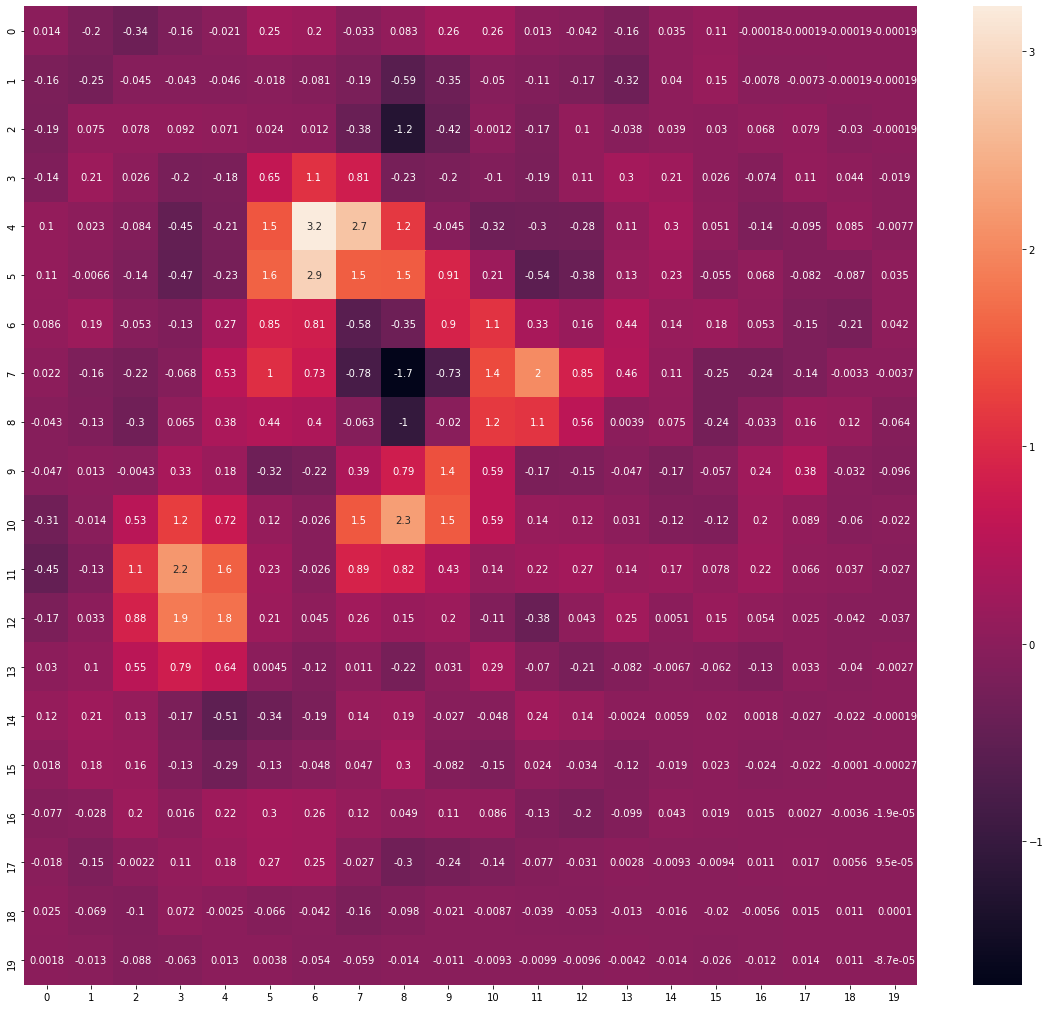

In [182]:
pred = np.loadtxt('test.txt')
fig, ax = plt.subplots(1, 1, figsize=(20, 18))
sns.heatmap(pred[0:20, 40:60], annot=True, ax=ax)

## Test for one random batch

In [ ]:
# Test for one random batch
plt.rcParams.update({'figure.max_open_warning': 0})
CUDA_LAUNCH_BLOCKING="1"

criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()

# path1 = 'model/model1-11.12.pt'
# model1 = NetTranslation4()
# model1.load_state_dict(torch.load(path1))
# model1 = model1.to(device)

path1 = 'model/model1-12.13-net5-norm-32-splat.pt'
model1 = NetTranslation5_norm()
model1.load_state_dict(torch.load(path1))
model1 = model1.to(device)
model1.eval()

for t, sample in enumerate(sensor_input_test_dataloader):
    if t == 0:
        continue
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_num = sample['target_num'].to(device)
    y_num2  = np.array(sample['target_num'])
    y_float = np.array(sample['target_float'])
    y_float = my_uncollate(y_num2, y_float)
    indx = np.array(sample['index'])

    pred_matrix = model1(X)

    loss_matrix = criterion1(pred_matrix, y)
    print('loss matrix =', loss_matrix.item())

    losses = []
    for i, pred, yy in zip(range(len(y)), pred_matrix, y):
        pred, yy = pred[0].data.cpu().numpy(), yy[0].data.cpu().numpy()
        loss = Metrics.mseloss(pred, yy)
        losses.append((i, loss))
    losses.sort(key=lambda x : x[1])
    for idx, (i, loss) in enumerate(losses):
        print('{}: matrix loss = {:.5f}'.format(i, loss), end='   ')
        if idx % 5 == 4: 
            print()
    print()

    pred_matrix = pred_matrix.data.cpu().numpy()   # not using .numpy() will cause big issue
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, y_num2, y_float, indx, Default.grid_length, peak_threshold=1, debug=True)
    errors = [val for sublist in errors for val in sublist]
    print('error', np.mean(errors), np.std(errors))
    print('miss ', np.sum(misses) / np.sum(y_num2))
    print('false', np.sum(falses) / np.sum(y_num2))
    break

X    = X.data.cpu().numpy()
# pred_matrix = pred_matrix.data.cpu().numpy()
# pred_ntx = pred_ntx.data.cpu().numpy()
y    = y.data.cpu().numpy()
indx = sample['index']

In [ ]:
# visualize the batch

for i in range(len(pred_matrix)):
    myplot(X[i], pred_matrix[i], y_num2[i], y[i], indx[i], i)
    print(i, end=' ')

## Loss function

In [99]:
def mysoftmax(X):
    '''
    Args:
        X -- np.ndarray, n=2
    Return:
        np.ndarray, n=2
    '''
    X = np.exp(X)
    summ = np.sum(X, axis=1)
    for i in range(len(X)):
        X[i] /= summ[i]
    return X


def mylogsoftmax(X):
    '''
    Args:
        array -- np.ndarray, n=2
    Return:
        np.ndarray, n=2
    '''
    X = mysoftmax(X)
    return np.log(X)


def mynllloss(X, y):
    '''
    Args:
        X -- np.ndarray, n=2
        y -- np.ndarray, n=1
    Return:
        float
    '''
    weight = np.ones(len(y))
    L = [0] * len(X)
    denominator = 0
    for i in range(len(X)):
        L[i] = -weight[y[i]] * X[i][y[i]]
        denominator += weight[y[i]]
    summ = 0
    for i in range(len(X)):
        summ += L[i] / denominator
    return summ


pred_ntx2 = pred_ntx.data.cpu().numpy()
y_num2 = y_num.data.cpu().numpy()

softmax     = nn.Softmax(dim=1)
log_softmax = nn.LogSoftmax(dim=1)
nllloss     = nn.NLLLoss()

loss = cross_entro_loss(pred_ntx, y_num-1)
print(loss.item())

loss = nllloss(log_softmax(pred_ntx), y_num-1)
print(loss.item())

loss = mynllloss(mylogsoftmax(pred_ntx2), y_num2-1)
print(loss)

1.6348114013671875
1.6348114013671875
1.634811419993639


In [101]:
def mymseloss(pred, y):
    '''
    Args:
        pred -- np.ndarray, n=2
        y    -- np.ndarray, n=2
    Return:
        float
    '''
    n = len(pred) * len(pred[0])
    summ = np.sum((pred - y)**2)
    return summ / n